# Predicting FIFA 23 Player Ratings

Now that FIFA 23 is out, I have more data to work with for predicting player ratings. I will perform some basic feature engineering to decrease the number of variables first, followed by some Exploratory Data Analysis. After that, I will run a few different 'base' models without adjusting Hyperparameters. After which, I will perform an 'Informed Search' on the best model. An 'Informed Search' is when you first run a somewhat large Randomized search to find a smaller range for each Hyperparameter that performs well. After this, you run a Grid Search on the small range of Hyperparameter values to find the best model.

## Loading in the Data and Feature Engineering

In [1]:
#Loading in required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
data = pd.read_csv('fut_data.csv')
print(data.shape)

(9439, 85)


After adding data from the 2021-2022 season, we have 9,439 observations, up from around 7,500. 85 variables is quite a bit though, so I will decrease this by combining certain other columns.

In [3]:
print(data.columns)

Index(['Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', 'MP',
       'Starts', 'Min', 'Gls', 'Ast', 'PK', 'PKatt', 'CrdY', 'CrdR', 'Sh',
       'SoT', 'Avg_Sh_Dist', 'FK', 'Pas_TotDist', 'Pas_PrgDist', 'Cmp_S',
       'Att_S', 'Cmp_M', 'Att_M', 'Cmp_L', 'Att_L', 'KP', 'Pas_A3', 'PPA',
       'CrsPA', '2CrdY', 'Fls', 'Fld', 'Off', 'Crs', 'PKwon', 'PKcon', 'OG',
       'Recov', 'AD_Won', 'AD_Lost', 'Touches', 'Tch_DP', 'Tch_D3', 'Tch_M3',
       'Tch_A3', 'Tch_AP', 'Live', 'Dr_Succ', 'Dr_Att', 'Num_Dr_Past', 'Megs',
       'Carries', 'Cr_TotDist', 'Cr_PrgDist', 'Cr_Prog', 'Cr_A3', 'CPA', 'Mis',
       'Dis', 'Targ', 'Rec', 'Prog_Pas_Rec', 'TklW', 'Tkl_D3', 'Tkl_M3',
       'Tkl_A3', 'Tkl_VD', 'Past', 'Press', 'Press_Succ', 'Pr_D3', 'Pr_M3',
       'Pr_A3', 'Blocks', 'Blk_Sh', 'ShSv', 'Blk_Pass', 'Int', 'Clr', 'Err',
       'Overall', 'Game'],
      dtype='object')


There are a few different groupings of columns that can be combined, such as 'Cmp_S', 'Cmp_M' and 'Cmp_L'. Doing this for a few different groups of variables will decrease the total number of variables by quite a bit.

In [4]:
data['Pass_Completed'] = data['Cmp_S'] + data['Cmp_M'] + data['Cmp_L'] #merging all the pass completions into 1 column

data['Pass_Attempted'] =  data['Att_S'] + data['Att_M'] + data['Att_L'] #merging all the pass attempts into 1 column

data['Total_Tackles'] = data['Tkl_D3'] + data['Tkl_M3'] + data['Tkl_A3'] #merging all the tackle locations itno 1 column

drop = ['Cmp_S', 'Cmp_M', 'Cmp_L', 
        'Att_S', 'Att_M', 'Att_L', 
        'Tkl_D3', 'Tkl_M3', 'Tkl_A3',
        'Tch_DP', 'Tch_D3', 'Tch_M3', 'Tch_A3', 'Tch_AP', #total 'Touches' is already in, so just drop others
        'Pr_D3', 'Pr_M3', 'Pr_A3'] #total 'Press' is already in, so just drop others

data = data.drop(drop, axis=1)

print(data.shape)

(9439, 71)


We can see that 14 columns have been removed from the data. Now that Feature Engineering is finished, let's do some Exploratory Data Analysis.

## Exploratory Data Analysis

Since 'Overall' rating is the target variable, let's take a look at it first.

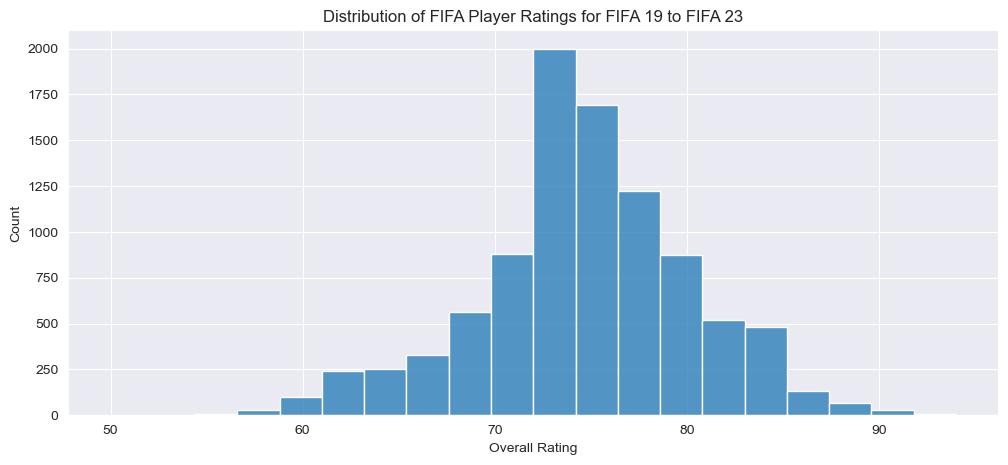

Summary Statistics for "Rating":
count    9439.000000
mean       74.578981
std         5.658791
min        50.000000
25%        71.000000
50%        75.000000
75%        78.000000
max        94.000000
Name: Overall, dtype: float64


In [5]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 5))
sns.histplot(x='Overall', data=data, bins=20)
plt.title('Distribution of FIFA Player Ratings for FIFA 19 to FIFA 23')
plt.xlabel('Overall Rating')
plt.show()
print('Summary Statistics for "Rating":')
print(data.Overall.describe())

We can see that there is a mean 'Overall' rating of around 75. 50% of the players have a rating between 71 and 78. An IQR of 7 suggests that players with a rating below 61 or above 88 are outliers. The histogram looks roughly normally distributed, with maybe a slight left skew. Let's take a look at the distribution of 'Overall' for each FIFA game next.

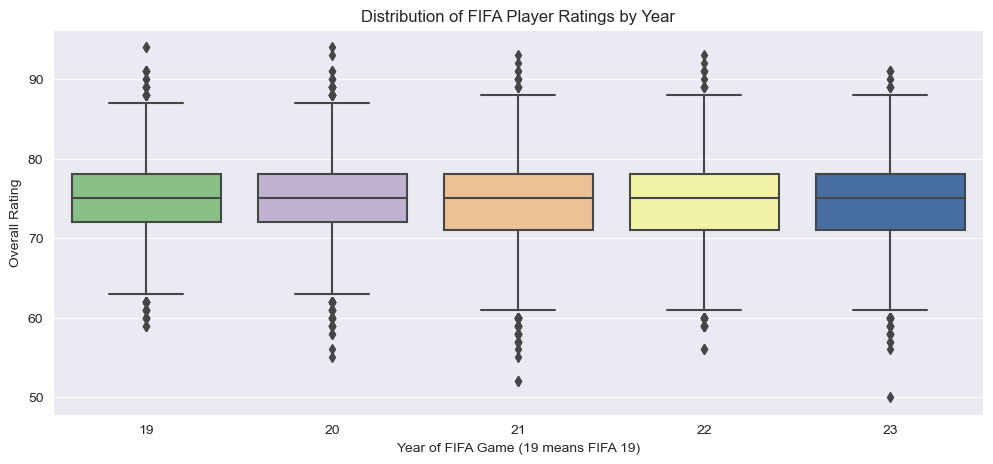

In [6]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='Game', y='Overall', data=data, palette='Accent')
plt.title('Distribution of FIFA Player Ratings by Year')
plt.xlabel('Year of FIFA Game (19 means FIFA 19)')
plt.ylabel('Overall Rating')
plt.show()

The data looks pretty consistent across all the FIFA games, a median of around 75 with 50% of the data falling between 70 and 80. The higher rated players that appear as outliers will be kept, as it makes sense for the elite players to be differentiated as there are not very many players who get a rating in the 90s every year. Let's see if setting a threshold of 'Min', or minutes played, will remove any of the lower rated players, as it seems likely that players who get very little playing time will be the worse players and therefore have a lower rating. 

In [7]:
print('Summary Statistics for Total Minutes Played:')
print(data.Min.describe())

Summary Statistics for Total Minutes Played:
count    9439.000000
mean     1517.875305
std      1022.008726
min         1.000000
25%       624.500000
50%      1482.000000
75%      2326.500000
max      4547.000000
Name: Min, dtype: float64


75% of players in the data have played at least 624.5 minutes while 50% have played at least 1,482 minutes. A standard football game is 90 minutes. It seems unlikely that an 'Overall' rating could be predicted with very little playing time, so let's set a cut off of 360 minutes, or 4 total games.

In [8]:
x = len(data[data['Min'] < 360])
print('Number of players with less than 360 minutes played:', x)

y = round(x/len(data)*100, 2)
print('\nPercentage of rows:', str(y)+'%')

Number of players with less than 360 minutes played: 1663

Percentage of rows: 17.62%


17.62% of the data might seem like a lot to remove, but we will still be left with almost 8,000 observations. Let's see how removing these players affects the previous graphs.

In [9]:
data = data[data['Min'] >= 360]

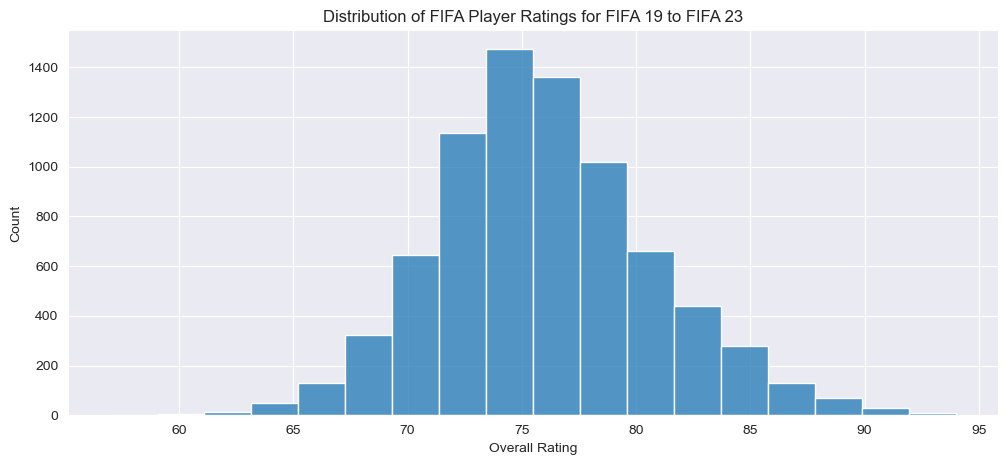

In [10]:
plt.figure(figsize=(12, 5))
sns.histplot(x='Overall', data=data, bins=18)
plt.title('Distribution of FIFA Player Ratings for FIFA 19 to FIFA 23')
plt.xlabel('Overall Rating')
plt.show()

I'd say the histogram of 'Overall' looks slightly better, there is more of a bell shape curve, meaning it looks more normally distributed. There might be a slight right skew now, however, given that it was mostly lower rated players that were removed.

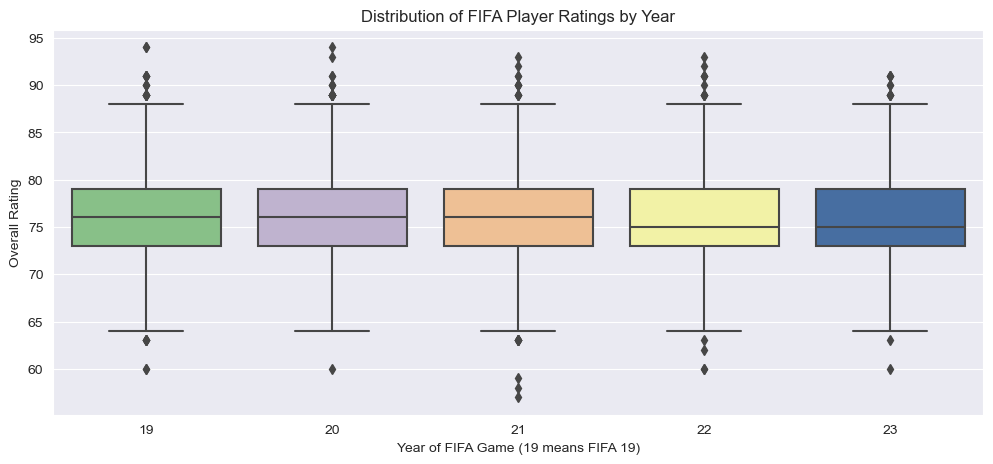

In [11]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='Game', y='Overall', data=data, palette='Accent')
plt.title('Distribution of FIFA Player Ratings by Year')
plt.xlabel('Year of FIFA Game (19 means FIFA 19)')
plt.ylabel('Overall Rating')
plt.show()

After removing players with less than 360 minutes played, we are left with less outliers for lower 'Overall' ratings. This validates my point earlier that the lower rated players likely had played fewer minutes. Let's take a look at a few other variables next, starting with 'Pos', or Position.

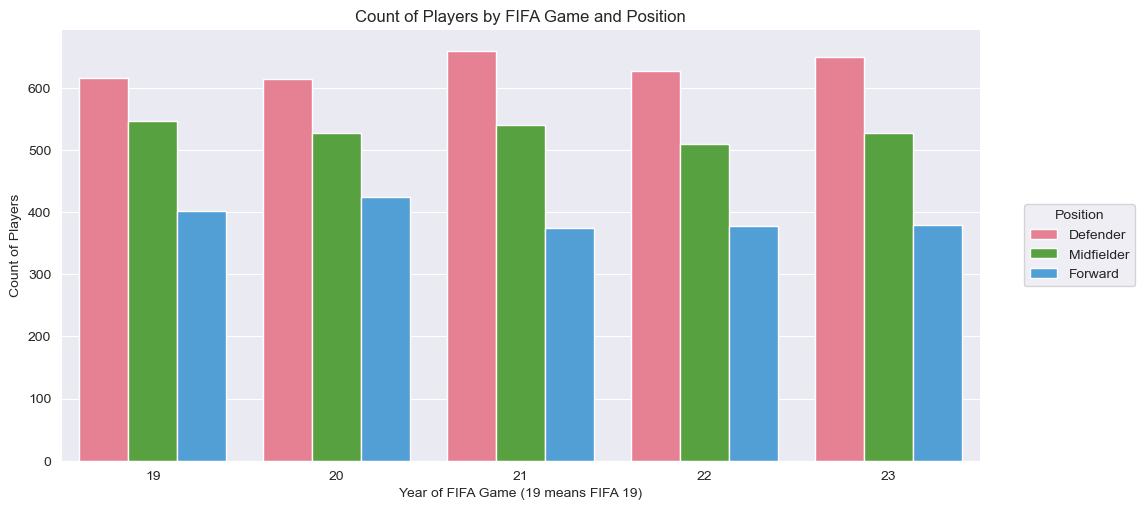

In [12]:
sns.catplot(x='Game', data=data, hue='Pos', kind='count', height=5, aspect=2, legend=False, palette='husl')
plt.xlabel('Year of FIFA Game (19 means FIFA 19)')
plt.ylabel('Count of Players')
plt.title('Count of Players by FIFA Game and Position')
plt.legend(title = 'Position', labels=['Defender', 'Midfielder', 'Forward'], bbox_to_anchor=(1.04,0.5), loc="center left")
plt.show()

The number of players in each position appears to have stayed the same across all the games. Next, let's see if 'Overall' varies at all by Position.

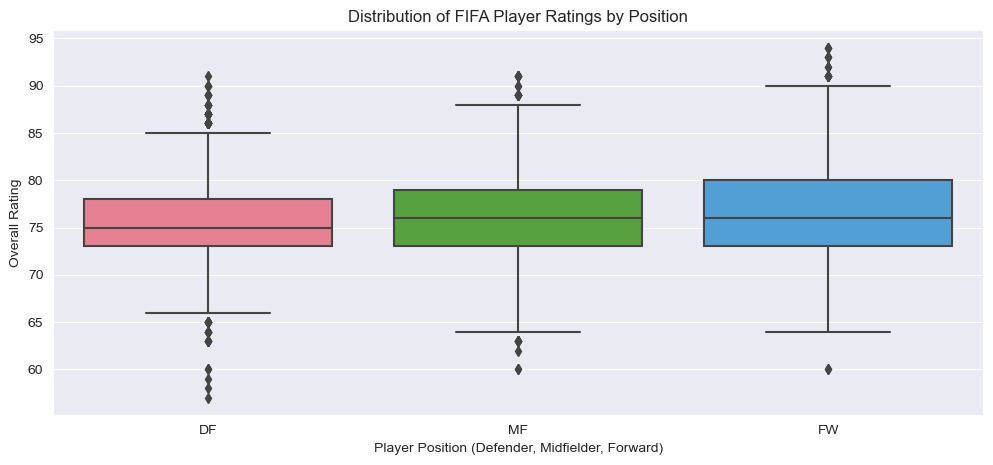

In [13]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='Pos', y='Overall', data=data, palette='husl')
plt.title('Distribution of FIFA Player Ratings by Position')
plt.xlabel('Player Position (Defender, Midfielder, Forward)')
plt.ylabel('Overall Rating')
plt.show()

From the box plots above, it looks like, on average, Defenders have the lowest 'Overall' rating of all 3 position groups. Forwards appear to have the largest variance in rating, however, with the largest IQR. Next, let's look at a cross tabulation of 'Comp', or which League the player is in, and 'Game'.

In [14]:
display(pd.crosstab(data['Comp'], data['Game'], margins=True))

Game,19,20,21,22,23,All
Comp,,,,,,
Bundesliga,307,314,304,302,291,1518
La Liga,272,265,275,256,265,1333
Ligue 1,305,300,288,288,306,1487
Premier League,337,355,359,339,339,1729
Serie A,342,332,349,329,357,1709
All,1563,1566,1575,1514,1558,7776


The table above shows the number of players from each league in each game. We can see that we have a range of 1,514 to 1,575 players from each game, which is pretty balanced. Each league has between 1,333 and 1,729 players present in the data, with both the English Premier League (EPL) and the Italian Serie A having over 1,700. There is some imbalance here, but the range is not too large. It is likely that there are fewer players from the Spanish La Liga and French Ligue 1 due to player's names being stored differently in the real-life game data and the FIFA ratings data; French and Spanish have more accented characters than German, English and Italian, and therefore there were likely less matches. The German Bundesliga also only has 18 teams compared to other leagues all having 20 teams, so that's why the Bundesliga numbers are slightly lower than EPL and Serie A. Let's look at the relationship between 'Comp' and 'Overall' next.

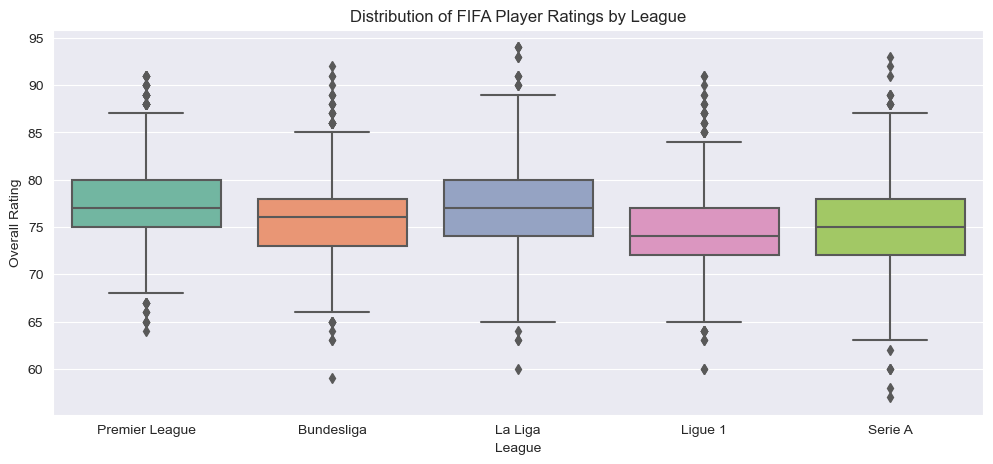

In [15]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='Comp', y='Overall', data=data, palette='Set2')
plt.title('Distribution of FIFA Player Ratings by League')
plt.xlabel('League')
plt.ylabel('Overall Rating')
plt.show()

If you are a big soccer fan, the box plots above should not be surprising. The English Premier League (EPL) and the Spanish La Liga appear to have, on average, higher rated players than the other 3 leagues. These two leagues are often considered the best 2 in the world, so to have higher rated players is not surprising. The German Bundesliga appears to be next highest, followed by the Italian Serie A and lastly by the French League 1. Interestingly, Serie A appears to have the most points viewed as Outliers for lower rated players. Maybe there are more young players in this league? 

Now that we have taken a look at how 'Overall' varies across multiple categorical predictors, let's compare it to a few of the numerical variables.

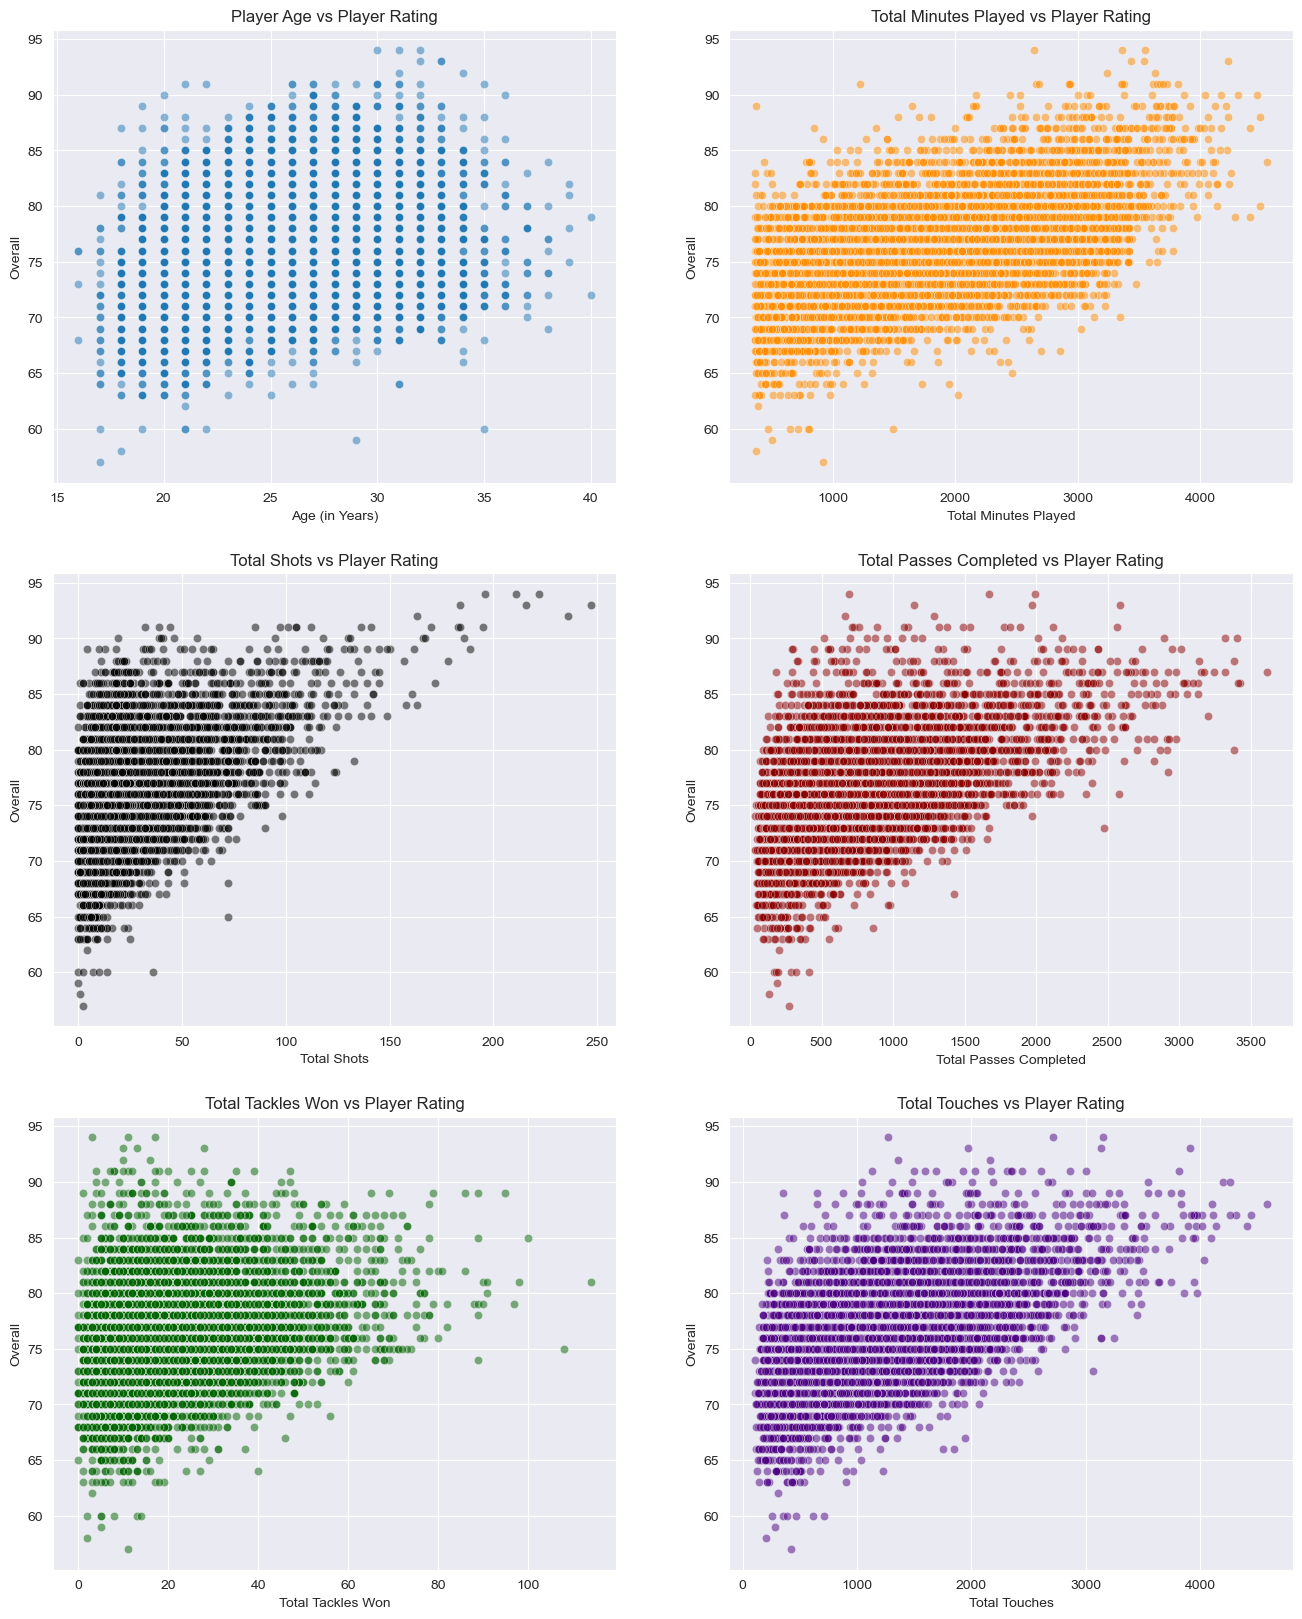

In [16]:
fig, axes = plt.subplots(3, 2, figsize=(16, 20))

sns.scatterplot(ax=axes[0,0], data=data, x='Age', y='Overall', alpha=0.5).set_title('Player Age vs Player Rating')
axes[0,0].set(xlabel='Age (in Years)')

sns.scatterplot(ax=axes[0,1], data=data, x='Min', y='Overall', color='darkorange', 
                alpha=0.5).set_title('Total Minutes Played vs Player Rating')
axes[0,1].set(xlabel='Total Minutes Played')

sns.scatterplot(ax=axes[1,0], data=data, x='Sh', y='Overall', color='black',
                alpha=0.5).set_title('Total Shots vs Player Rating')
axes[1,0].set(xlabel='Total Shots')

sns.scatterplot(ax=axes[1,1], data=data, x='Pass_Completed', y='Overall', color='darkred',
                alpha=0.5).set_title('Total Passes Completed vs Player Rating')
axes[1,1].set(xlabel='Total Passes Completed')

sns.scatterplot(ax=axes[2,0], data=data, x='TklW', y='Overall', color='darkgreen',
                alpha=0.5).set_title('Total Tackles Won vs Player Rating')
axes[2,0].set(xlabel='Total Tackles Won')

sns.scatterplot(ax=axes[2,1], data=data, x='Touches', y='Overall', color='indigo',
                alpha=0.5).set_title('Total Touches vs Player Rating')
axes[2,1].set(xlabel='Total Touches')

plt.show()

The first plot shows 'Age' vs 'Overall'. It looks like the players peak in 'Overall' rating in their late 20s and early 30s, which makes sense as this is usually the players 'prime'. 

The second plot shows 'Minutes Played' vs 'Overall'. There appears to be a moderately strong positive linear relationship between the two; the more minutes you play the higher your rating is likely to be. 

The third plot shows 'Total Shots' vs 'Overall'. It looks like there is a somewhat positive relationship, but it is definitely not linear. This makes sense though, as Forwards tend to get more shots compared to Defenders and Midfielders, so you cannot hold few shots for a Defender against him. Players with over 175 shots all have ratings around 90 or higher. 

The fourth plot shows 'Total Passes' vs 'Overall' Again, we see a somewhat positive relationship here. All of the players with more than 3000 passes have an 'Overall' rating that is 80 or higher.

The fifth plot shows 'Total Tackles Won' vs 'Overall'. There does not appear to be much of a relationship at all between these two variables. However, just like 'Total Shots', 'Total Tackles Won' is likely influenced by player position, as Defenders get far more tackles than Forwards and Midfielders. We can see a cluster of players in the top left with high ratings and low tackles, which are likely the elite forward players like Lionel Messi, Neymar and Cristiano Ronaldo. 

The last plot shows 'Total Touches' vs 'Overall'. Here we can see a somewhat strong positive linear relationship between the two. This makes sense, as better players are going to be touching the ball more frequently.

Now that we have taken a look at the relationship between 'Overall' rating and some of the predictor variables, let’s start making some models.

## Predicting 'Overall' Rating

In [17]:
#This function will be used to calculate and display the R^2 and RMSE of each model
def evaluate_model(model, x_train, y_train, x_test, y_test):
    start = time.time()
    model.fit(x_train, y_train)
    score = np.round(model.score(x_test, y_test), 4)
    preds = model.predict(x_test)
    rmse = np.round(mean_squared_error(y_test, preds, squared=False), 2)
    end = time.time()
    t = round(end-start, 4)
    print('R^2: {}, RMSE: {}\n'.format(score, rmse))
    print(f'Run Time: {t} seconds')
    return score, rmse, t

scores_list = [] # will be used to display model metrics at the end

### Some last preprocessing of the data

In [18]:
data = data.astype({'Game':'category', 'Comp':'category', 'Pos':'category'}) #change dtype so dummies can be created 

target = data[['Overall']] #target variable

d = data.drop(['Player', 'Nation', 'Squad', 'Born', 'Overall'], axis=1) #remove unneeded columns

features = pd.get_dummies(d, columns=['Pos', 'Comp', 'Game'], drop_first=True) #create dummy variables

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1996) #train test split

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train) #standardized data

X_test_scaled = scaler.transform(X_test) #transforming test data 

y_train = y_train.values.ravel() #changing format of y_train to array 

### Linear Regression

First I will run a basic Linear Regression model to use a baseline to compare more advanced models against.

In [19]:
#Linear Regression Model
lr = LinearRegression()

lr_r2, lr_rmse, lr_t = evaluate_model(lr, X_train_scaled, y_train, X_test_scaled, y_test)

print(f'\nStandard Deviation of "Overall": {round(target.std(), 3)}')

scores_list.append(['Linear Regression', lr_r2, lr_rmse, lr_t])

R^2: 0.6363, RMSE: 2.81

Run Time: 0.017 seconds

Standard Deviation of "Overall": Overall    4.655
dtype: float64


A $R^{2}$ value of 0.6363 implies that 63.63% of the variance of 'Overall' can be explained by the used predictor variables. A RMSE of 2.81 is lower than the variance of 'Overall', 4.655, indicating that this model is not bad. Next let's try a Random Forest Model.

### Random Forest

In [20]:
rf = RandomForestRegressor(random_state=1996)

rf_r2, rf_rmse, rf_t= evaluate_model(rf, X_train_scaled, y_train, X_test_scaled, y_test)

scores_list.append(['Random Forest', rf_r2, rf_rmse, rf_t])

R^2: 0.629, RMSE: 2.83

Run Time: 11.8642 seconds


Our $R^{2}$ value is slightly lower than the Linear Regression Model, and the run time is significantly longer, although still relatively short at roughly 12 seconds. Let's try a Gradient Boosting Model next.

### Gradient Boosting

In [21]:
gb = GradientBoostingRegressor(random_state=1996)

gb_r2, gb_rmse, gb_t = evaluate_model(gb, X_train_scaled, y_train, X_test_scaled, y_test)

scores_list.append(['Gradient Boosting', gb_r2, gb_rmse, gb_t])

R^2: 0.644, RMSE: 2.78

Run Time: 3.8148 seconds


This is the best model so far by. Although the run time is longer than the Linear Regression model, it is still short at roughly 4 seconds. Let's try some Hyperparameter tuning on a Gradient Boosting Model. I will be doing an 'Informed Search', starting with a Randomized Search on a large parameter grid. The results of the Randomized search will be used to find a smaller range of values to use in a Grid Search. 

In [22]:
#Create paramter grid for GB
max_depth = list(range(5, 26))
learning_rate = np.arange(0.01, 0.21, 0.01).tolist()
n_estimators = np.arange(100, 1050, 50).tolist()
#21*20*19 HP options, roughly 8000 total

gb_params = {'max_depth': max_depth,
             'learning_rate': learning_rate,
             'n_estimators': n_estimators}

In [23]:
gb2 = GradientBoostingRegressor(random_state=1996)

gb_rand = RandomizedSearchCV(gb2, gb_params, n_iter=200, cv=3, verbose=2, n_jobs=-1, random_state=717)

gb_rand.fit(X_train_scaled, y_train)


print(gb_rand.best_params_)
#print('\n')
#print(gb_rand.best_score_)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05}


In [24]:
gb_r = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, random_state=1996)

gbr_r2, gbr_rmse, gbr_t = evaluate_model(gb_r, X_train_scaled, y_train, X_test_scaled, y_test)

scores_list.append(['Gradient Boosting w/ Random Search', gbr_r2, gbr_rmse, gbr_t])

R^2: 0.657, RMSE: 2.73

Run Time: 31.8962 seconds


We can see that the best hyperparameter combination found was 500 trees with a max depth of 5 and a learning rate of 0.05. The $R^{2}$ value of 65.7% is the best so far. Let's take a look at some graphs of these 3 hyperparameters to find smaller ranges for each to run a grid search on.

In [25]:
df = pd.DataFrame(gb_rand.cv_results_)
df = df[['params', 'mean_test_score']]
scores = pd.concat([df, df.params.apply(pd.Series)], axis=1)
scores = scores.drop('params', axis=1)
#scores.to_csv('hp_200.csv')

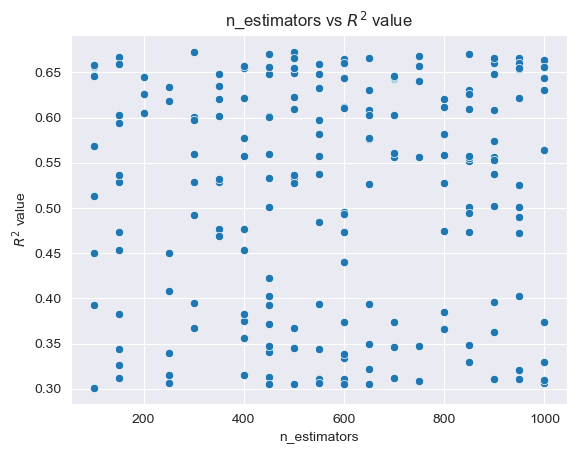

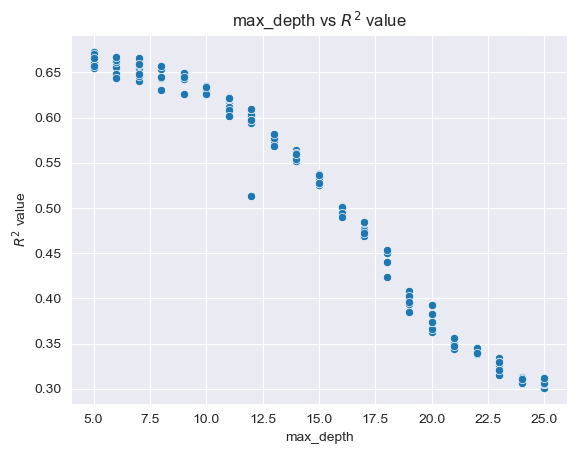

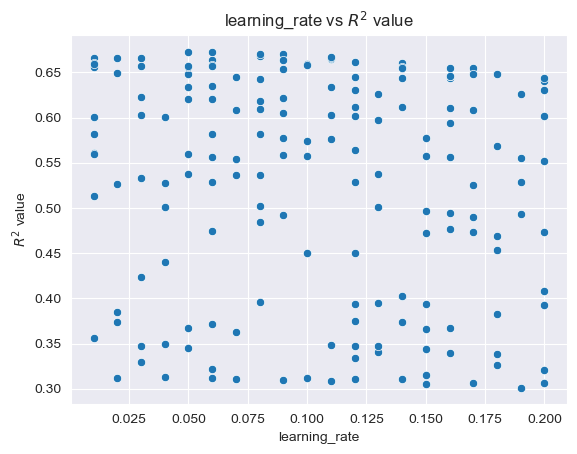

In [26]:
lst = ['n_estimators', 'max_depth', 'learning_rate']

for l in lst:
    sns.scatterplot(x=l, y='mean_test_score', data=scores)
    plt.title(f'{l} vs $R^{2}$ value')
    plt.xlabel(f'{l}')
    plt.ylabel('$R^{2}$ value')
    plt.show()

It looks like 400-600 estimators, a max depth of 5 to 7 and a learning rate of 0.05 to 0.09 are the ranges that should be used in the grid search. 

In [28]:
#Create paramter grid for GB
max_depth = [5, 6, 7]
learning_rate = [0.05, 0.06, 0.07, 0.08, 0.09]
n_estimators = [300, 350, 400, 450, 500]

gb_params = {'max_depth': max_depth,
             'learning_rate': learning_rate,
             'n_estimators': n_estimators}

In [29]:
gb3 = GradientBoostingRegressor(random_state=1996)

gb_grid = GridSearchCV(gb3, gb_params, cv=3, verbose=2, n_jobs=-1)

gb_grid.fit(X_train_scaled, y_train)

print(gb_grid.best_params_)

Fitting 3 folds for each of 75 candidates, totalling 225 fits
{'learning_rate': 0.09, 'max_depth': 5, 'n_estimators': 300}


After running a Grid Search, the best hyperparameter values are: max_depth of 5, 300 for n_estimators and learning_rate of 0.09. Let's see how well this model performs compared to the previous models.

In [30]:
gb_i = GradientBoostingRegressor(n_estimators=300, learning_rate=0.09, max_depth=5, random_state=1996)

gbi_r2, gbi_rmse, gbi_t = evaluate_model(gb_i, X_train_scaled, y_train, X_test_scaled, y_test)

scores_list.append(['Gradient Boosting w/ Informed Search', gbi_r2, gbi_rmse, gbi_t])

R^2: 0.6543, RMSE: 2.74

Run Time: 19.1113 seconds


In [31]:
scores_df = pd.DataFrame(scores_list, columns=['Model Type', 'R^2', 'RMSE', 'Run Time'])
display(scores_df)

,Model Type,R^2,RMSE,Run Time
0,Linear Regression,0.6363,2.81,0.0170
1,Random Forest,0.6290,2.83,11.8642
2,Gradient Boosting,0.6440,2.78,3.8148
3,Gradient Boosting w/ Random Search,0.6570,2.73,31.8962
4,Gradient Boosting w/ Informed Search,0.6543,2.74,19.1113


Interestingly, the Graident Boosting model performed slighly worse after performing the Grid Search, but only by 0.27%. The run time was about half of the previoius model, so I would argure that the best model is the last model, Gradient Boosting after an Informed search. The imporvement from the base linear regression is not much though, only roughly 2%.  

## Conclusion

The previous models, using data through the 2020-2021 season performed slightly better, with the best model having a $R^{2}$ of roughly 70.7%, which is around 5% better than the best model here. It seems somewhat counterintuitive that more data has resulted in worse results. However, the fact that $R^{2}$ has stayed around 66% furthers the findings of previous analysis that EA uses more than just this data for creating player ratings for the FIFA video game. 'Overall' rating is a combination of 6 sub scores, each of which has multiple sub scores as well. The 6 are: Pace (Speed/Acceleration), Shooting, Passing, Dribbling, Defense and Physical. 4 of the 6 can be accounted for with the used data, only Pace and Physical cannot. Given that 'Overall' is just a combination of these 6 scores, accounting for roughly 66% of the variation in 'Overall' is reasonable.